In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import glob
import os
import yaml
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=3, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


In [13]:
from postprocessing import report_model

records = []
for path in glob.glob('models/vary_sigma/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None:
        records.append(record)

for path in glob.glob('models/fixed_sigma/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None and record['objective'] == 'Relative density' and record['housing']:
        records.append(record)

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values(by=['objective', 'sigma', 'rel_val_err']).drop(columns='path').set_index(['objective', 'sigma', 'id'])

val_err  rel_val_err  val_loss  train_loss  \
objective        sigma id                                                       
Relative density 2     4137625_0  0.010132     0.639796  0.058512    0.000310   
                       4137633_0  0.010909     0.656615  0.059460    0.000329   
                       4137618_0  0.012786     0.734535  0.064556    0.000357   
                 3     3761106_5  0.008319     0.555950  0.059136    0.000312   
                       3701409_5  0.008196     0.569870  0.062450    0.000328   
                       4137633_1  0.007954     0.576406  0.061861    0.000318   
                       4137618_1  0.007204     0.576577  0.061240    0.000294   
                       4137625_1  0.009426     0.703058  0.072718    0.000435   
                       3761096_5  0.013818     0.848212  0.082111    0.000564   
                 4     4137625_2  0.005859     0.555802  0.064615    0.000330   
                       4137618_2  0.007878     0.722045  0.079234    0.000478   
                       4137633_2  0.007914     0.817446  0.091072    0.000453   
                 5     4137633_3  0.004391     0.496626  0.059253    0.000310   
                       4137625_3  0.004704     0.545656  0.065320    0.000295   
                       4137618_3  0.005788     0.644694  0.076019    0.000317   

                                  val_tmax  num_train_counties  housing  
objective        sigma id                                                
Relative density 2     4137625_0        10                  31     True  
                       4137633_0        10                  31     True  
                       4137618_0        10                  31     True  
                 3     3761106_5        10                  31     True  
                       3701409_5        10                  31     True  
                       4137633_1        10                  31     True  
                       4137618_1        10                  31     True  
                       4137625_1        10                  31     True  
                       3761096_5        10                  31     True  
                 4     4137625_2        10                  31     True  
                       4137618_2        10                  31     True  
                       4137633_2        10                  31     True  
                 5     4137633_3        10                  31     True  
                       4137625_3        10                  31     True  
                       4137618_3        10                  31     True

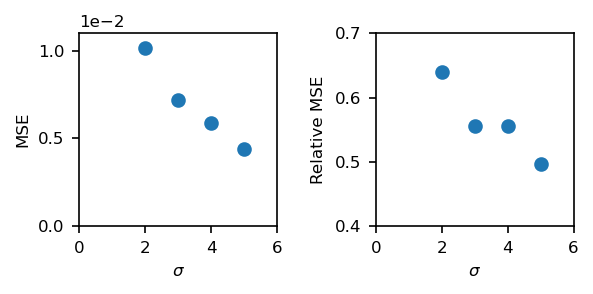

In [30]:
# Plot errors as a function of sigma

toplot = df.groupby('sigma')[['val_err', 'rel_val_err']].agg('min')

fig, ax = plt.subplots(1, 2, figsize=(4, 2), dpi=150)
ax[0].scatter(toplot.index, toplot.val_err)
ax[0].set(
    xlim=[0, 6],
    xlabel='$\sigma$',
    ylim=[0., 0.011],
    yticks=[0, 0.005, 0.01],
    ylabel='MSE'
)
ax[0].ticklabel_format(axis='y', scilimits=(0,0))

ax[1].scatter(toplot.index, toplot.rel_val_err)
ax[1].set(
    xlim=[0, 6],
    xlabel='$\sigma$',
    ylim=[0.4, 0.7],
    ylabel='Relative MSE'
)

plt.tight_layout()

## Relative density models at different sigma

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0101


For county = Georgia_Fulton
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00147 |    1.062  |
Spline extrapolation  |   0.00232 |    1.669  |
No dynamics           |   0.00139 |    1.000  |
For county = Illinois_Cook
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00508 |    0.379  |
Spline extrapolation  |     0.027 |    2.014  |
No dynamics           |    0.0134 |    1.000  |
For county = Texas_Harris
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00149 |    0.622  |
Spline extrapolation  |   0.00548 |    2.290  |
No dynamics           |   0.00239 |    1.000  |
For county = California_Los Angeles
-------------------

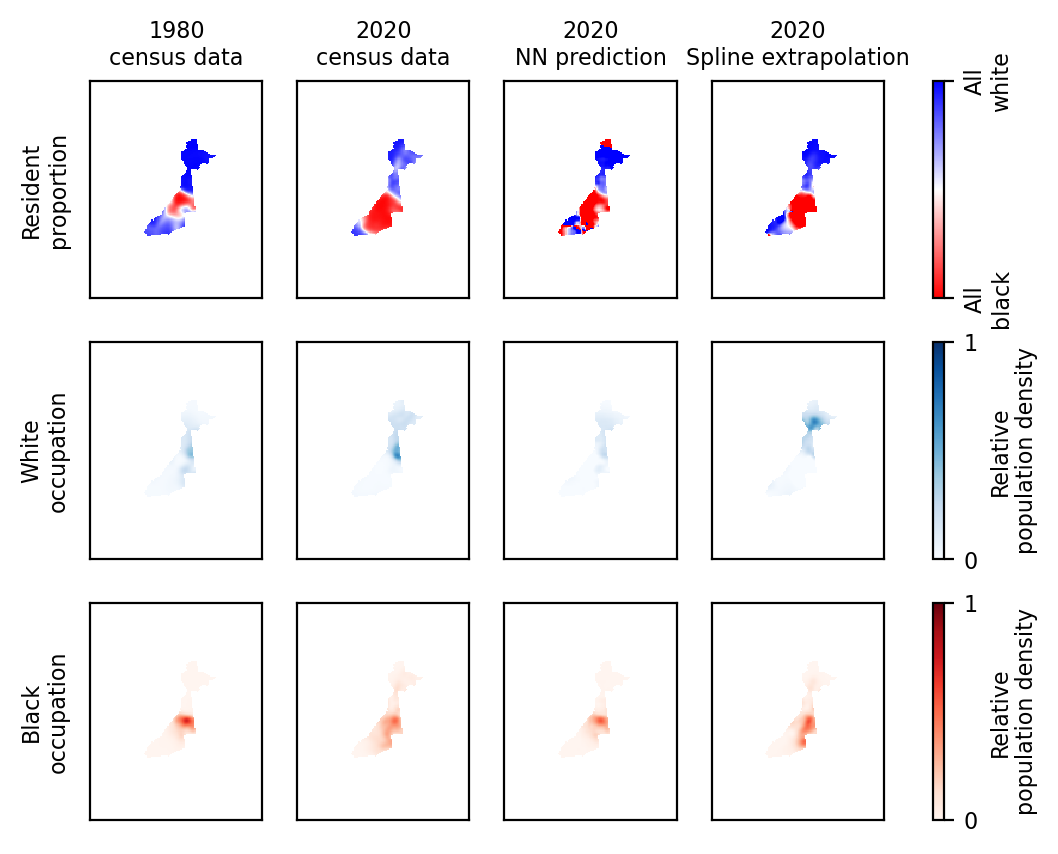

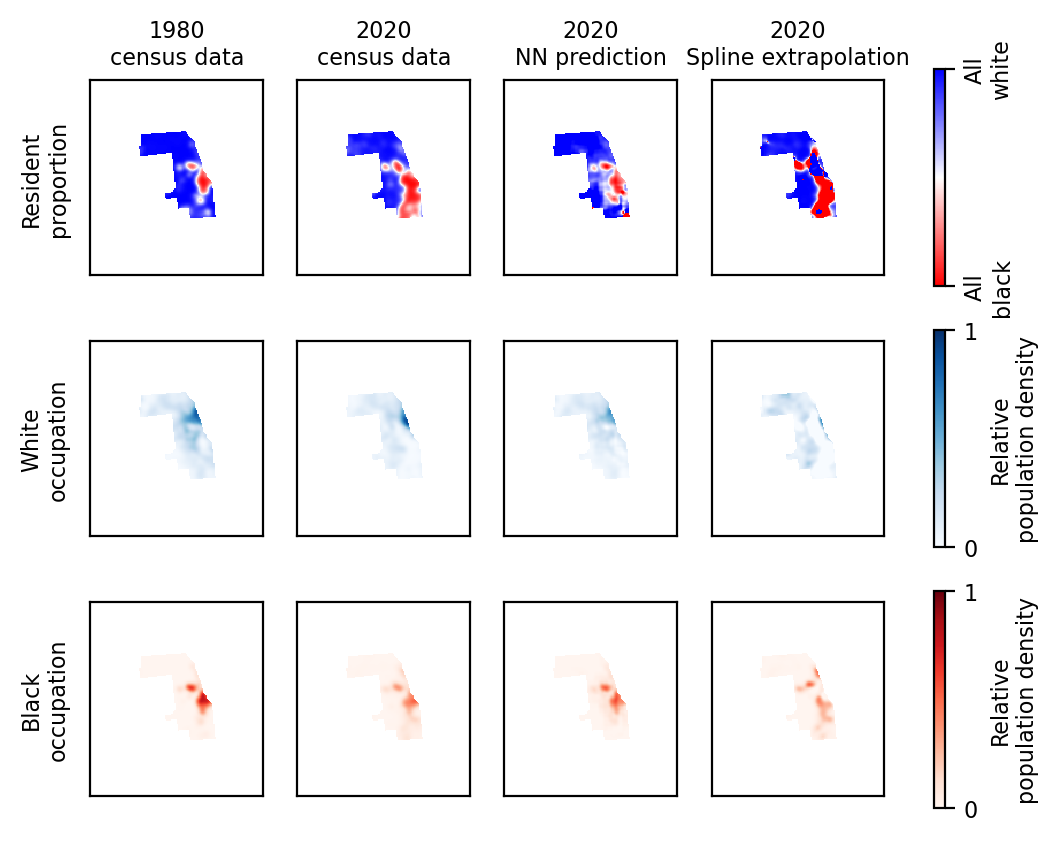

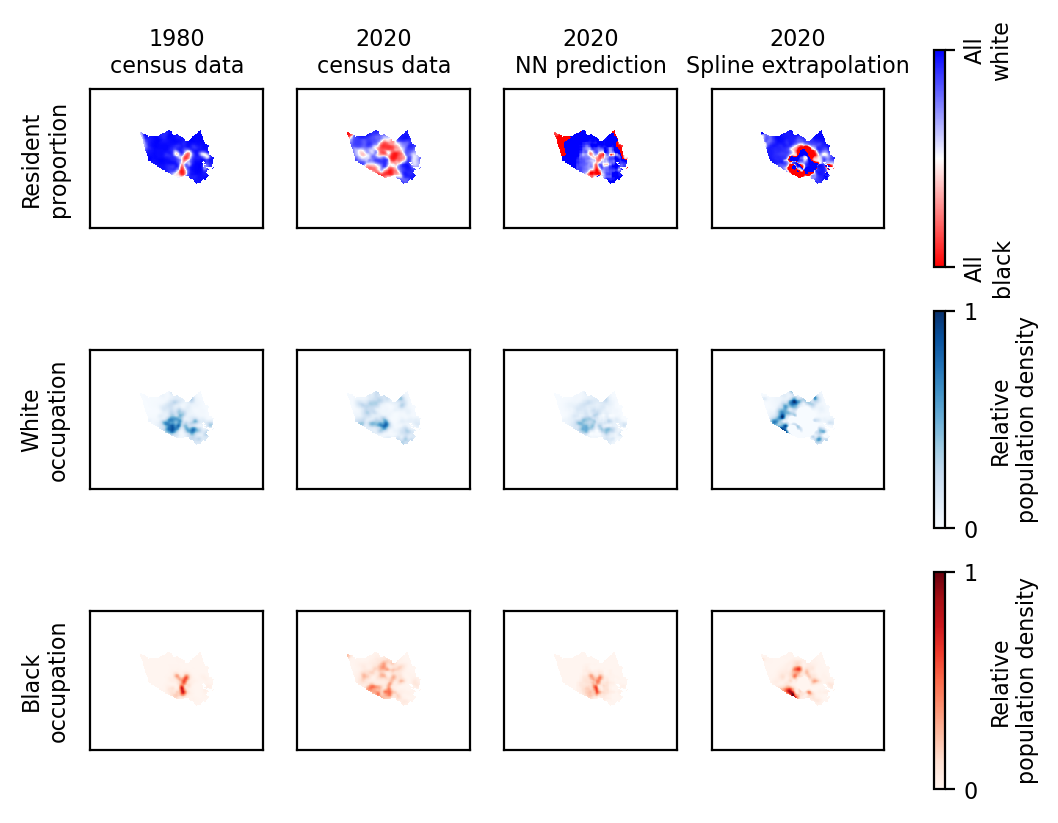

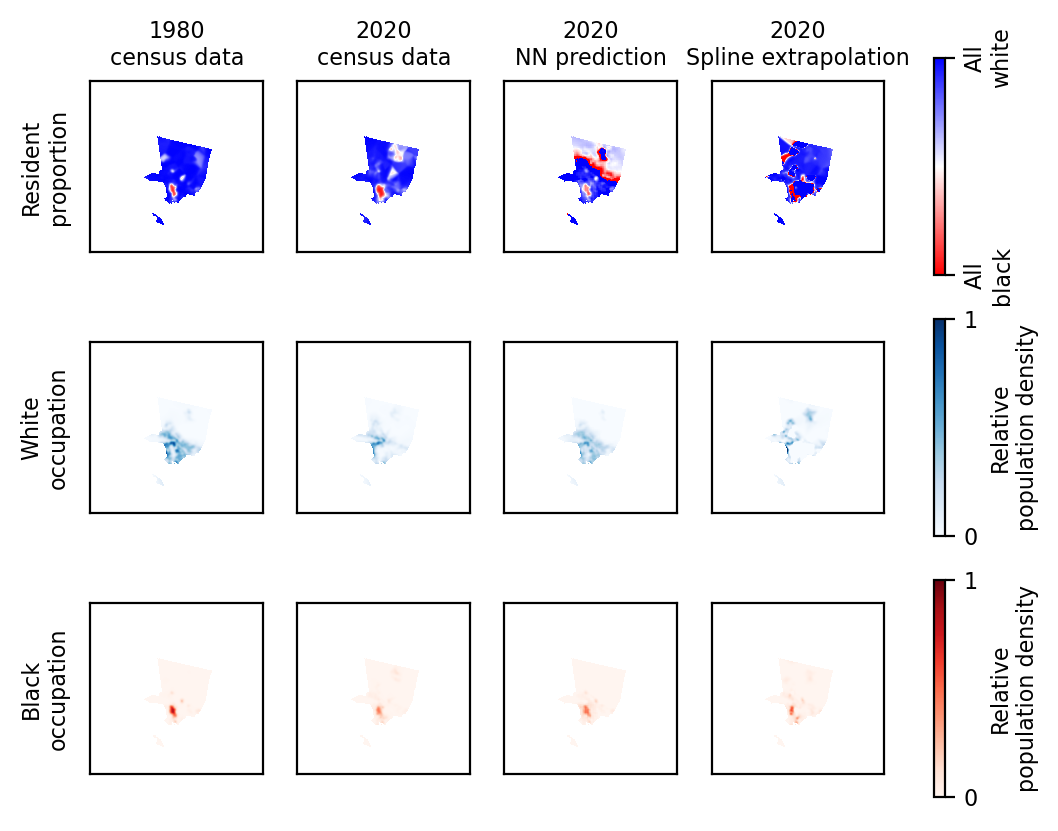

In [17]:
from train_census_nn import *
from pprint import pprint
import json

from postprocessing import make_predictions_plot

sub_df = df[(df.objective == 'Relative density') & (df.sigma == 2)].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/vary_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Deal with rearranged paths
if model in os.listdir('models/vary_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/vary_sigma/')
elif model in os.listdir('models/fixed_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')


model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.5g}')

In [18]:
from train_census_nn import *
from pprint import pprint
import json

from postprocessing import make_predictions_plot


sub_df = df[(df.objective == 'Relative density') & (df.sigma == 3)].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/vary_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# Deal with rearranged paths
if model in os.listdir('models/vary_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/vary_sigma/')
elif model in os.listdir('models/fixed_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.5g}')

FileNotFoundError: [Errno 2] No such file or directory: 'models/vary_sigma/3761106_5/config.yaml'

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00586


For county = Georgia_Fulton
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |  0.000735 |    0.762  |
Spline extrapolation  |   0.00146 |    1.514  |
No dynamics           |  0.000964 |    1.000  |
For county = Illinois_Cook
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00219 |    0.266  |
Spline extrapolation  |     0.016 |    1.949  |
No dynamics           |   0.00823 |    1.000  |
For county = Texas_Harris
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00101 |    0.625  |
Spline extrapolation  |   0.00345 |    2.132  |
No dynamics           |   0.00162 |    1.000  |
For county = California_Los Angeles
-------------------

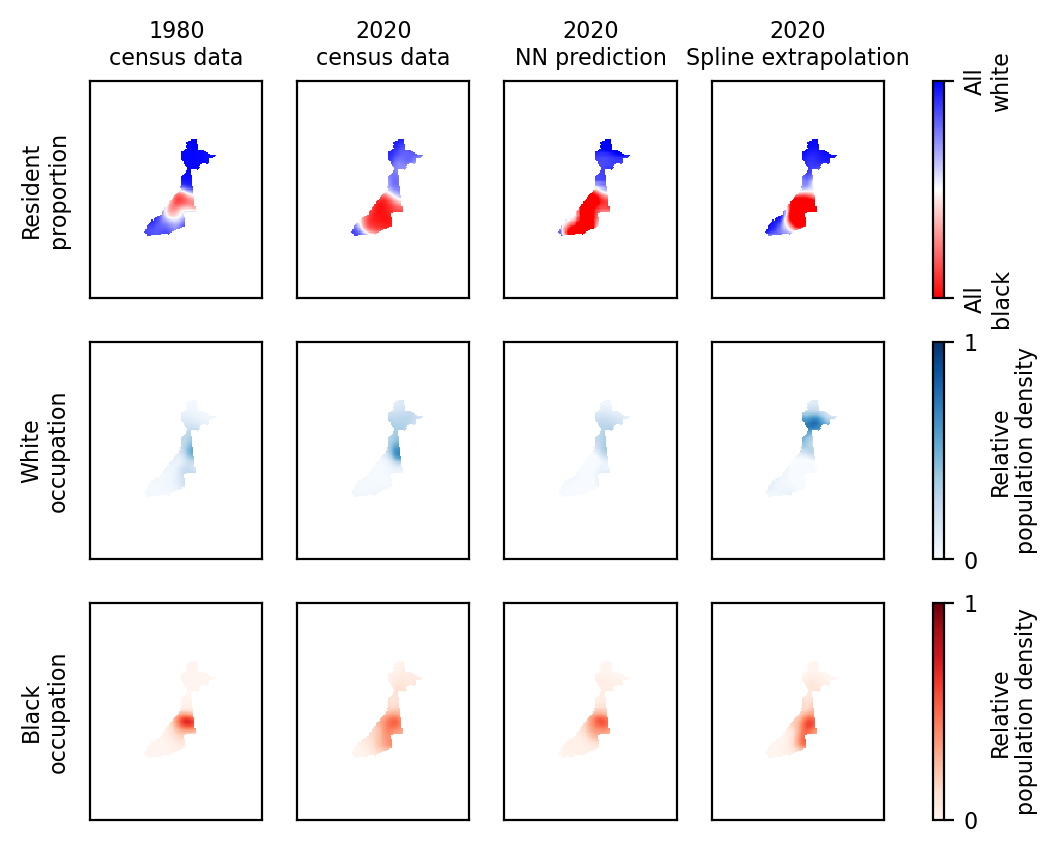

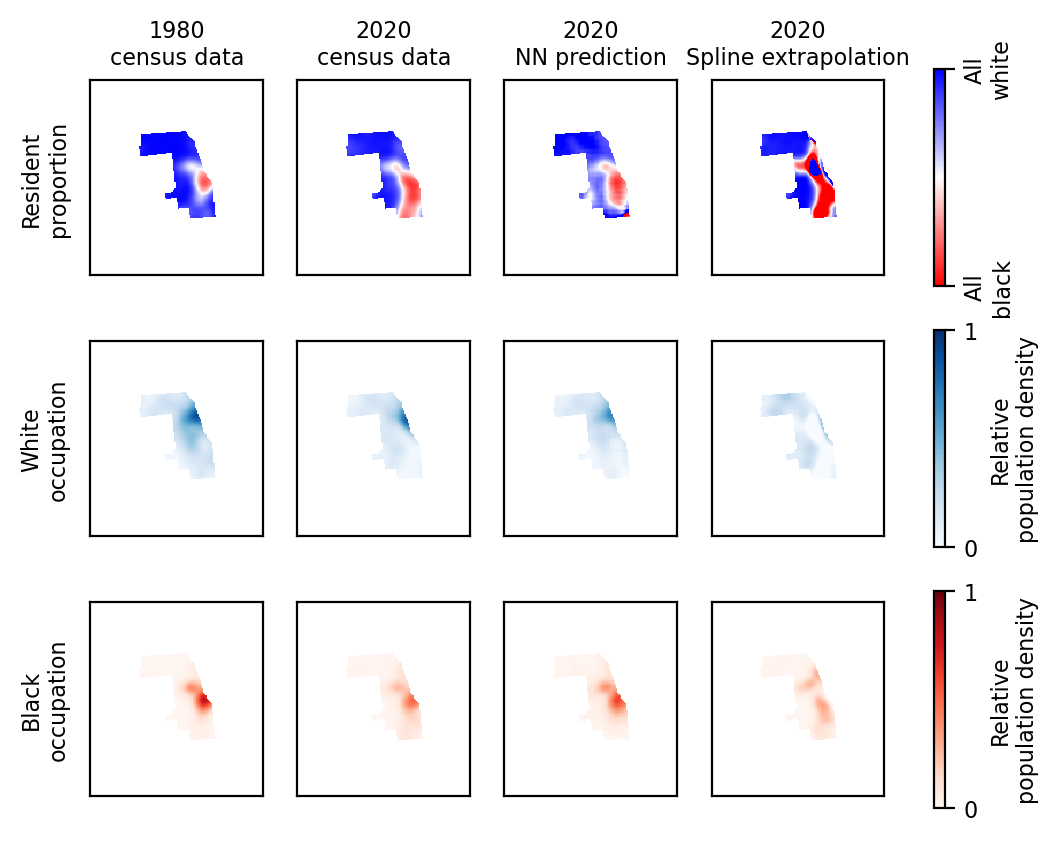

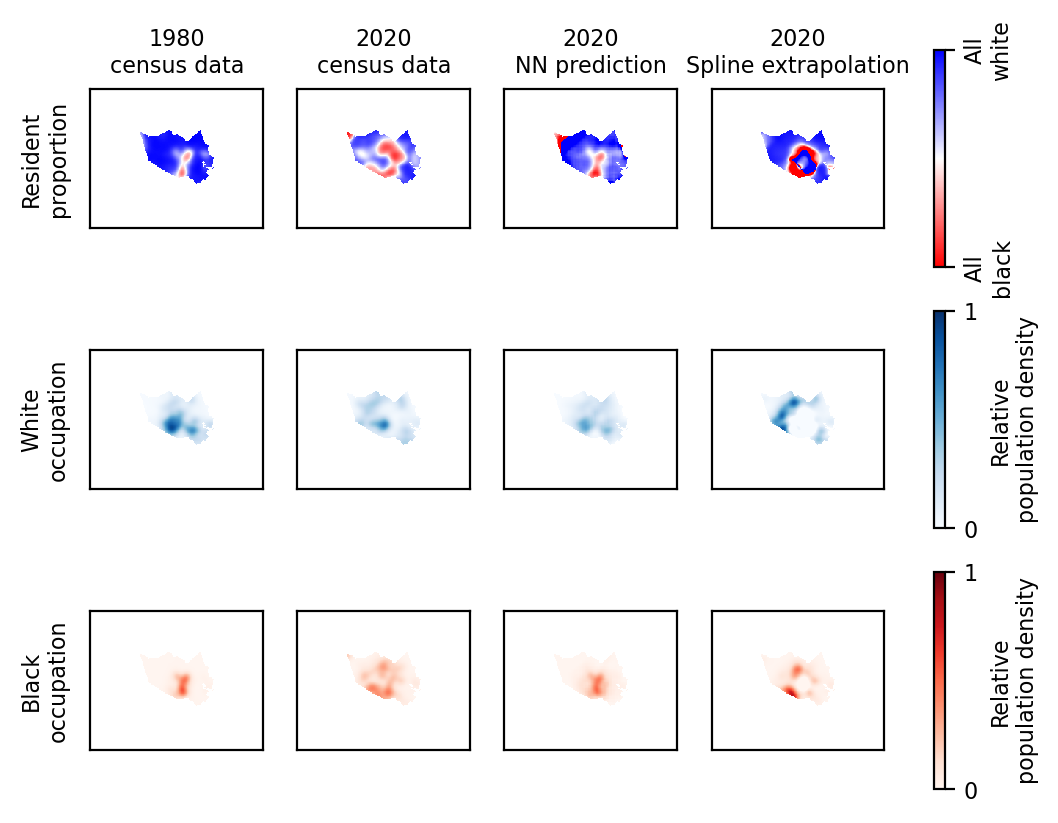

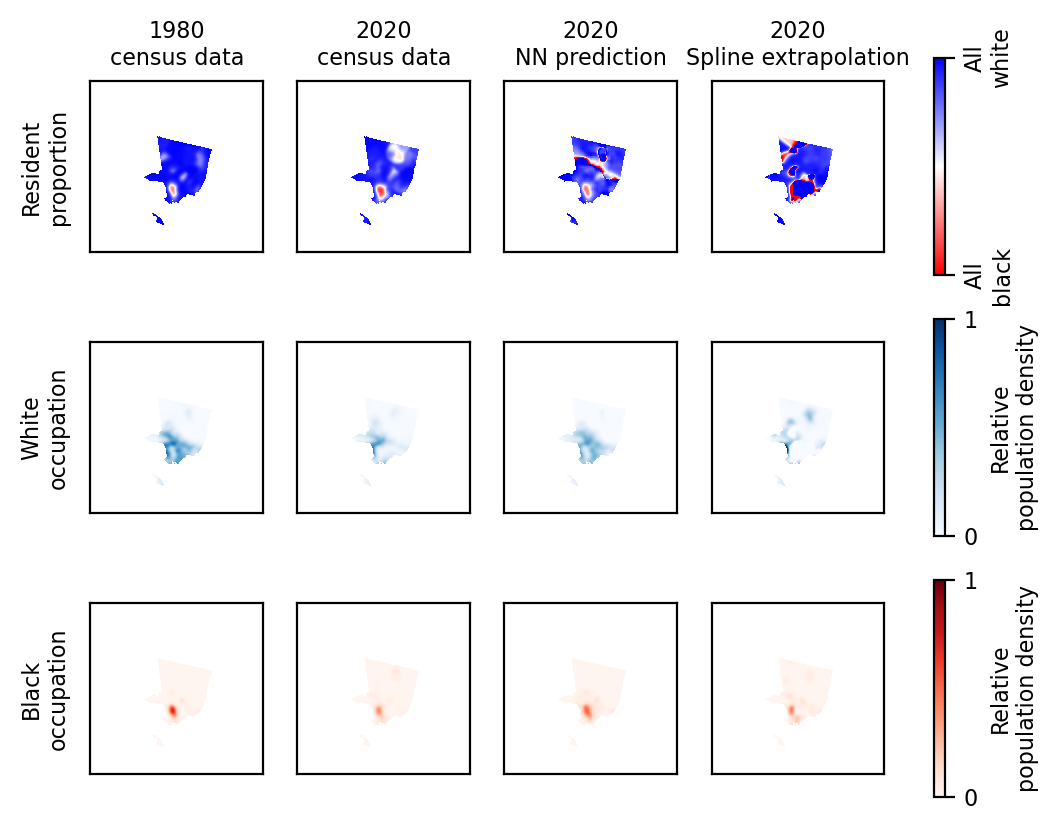

In [8]:
from train_census_nn import *
from pprint import pprint
import json

from postprocessing import make_predictions_plot


sub_df = df[(df.objective == 'Relative density') & (df.sigma == 4)].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/vary_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Deal with rearranged paths
if model in os.listdir('models/vary_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/vary_sigma/')
elif model in os.listdir('models/fixed_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.5g}')

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00586


For county = Georgia_Fulton
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |  0.000735 |    0.762  |
Spline extrapolation  |   0.00146 |    1.514  |
No dynamics           |  0.000964 |    1.000  |
For county = Illinois_Cook
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00219 |    0.266  |
Spline extrapolation  |     0.016 |    1.949  |
No dynamics           |   0.00823 |    1.000  |
For county = Texas_Harris
-----------------------------------------------
        Model         |   MSE     |  Rel. MSE |
-----------------------------------------------
Neural Network.       |   0.00101 |    0.625  |
Spline extrapolation  |   0.00345 |    2.132  |
No dynamics           |   0.00162 |    1.000  |
For county = California_Los Angeles
-------------------

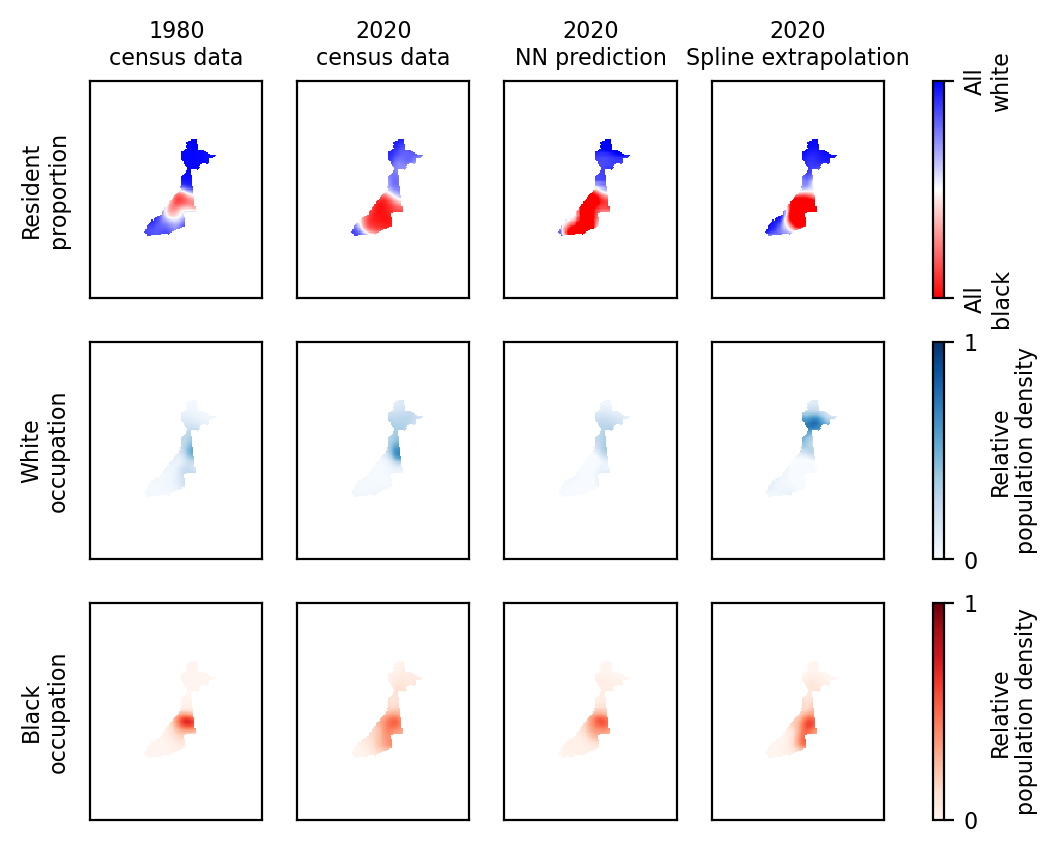

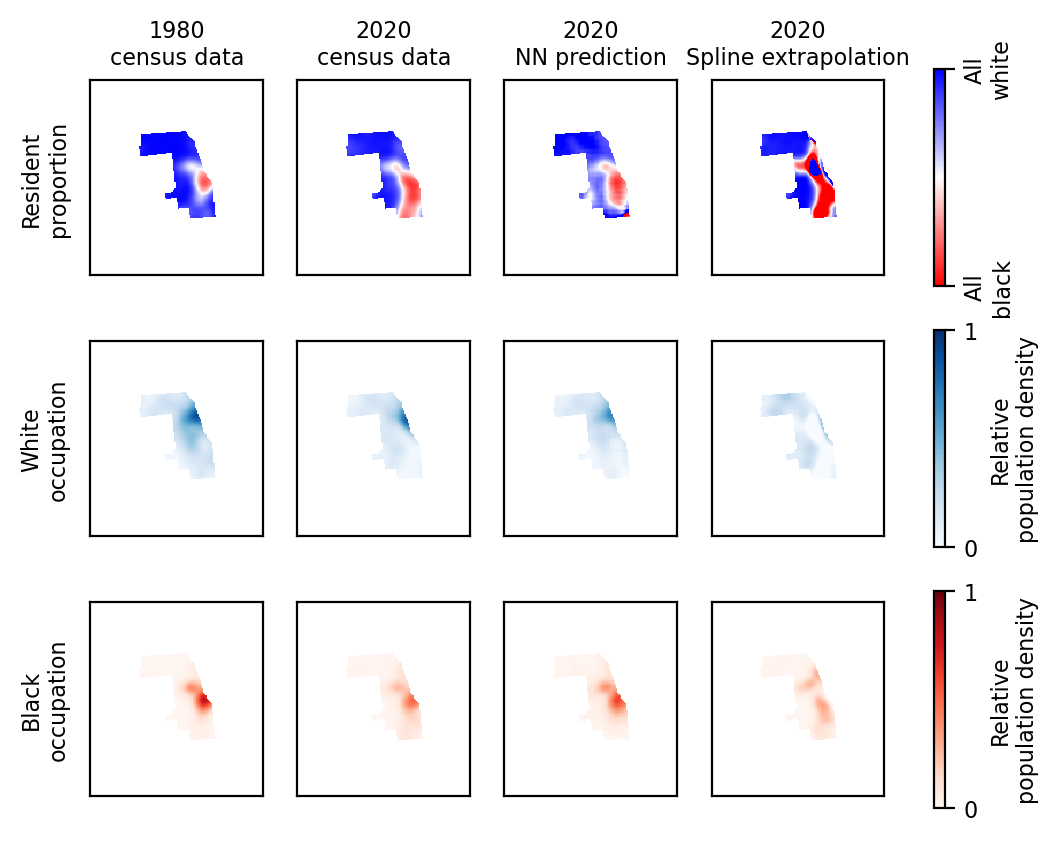

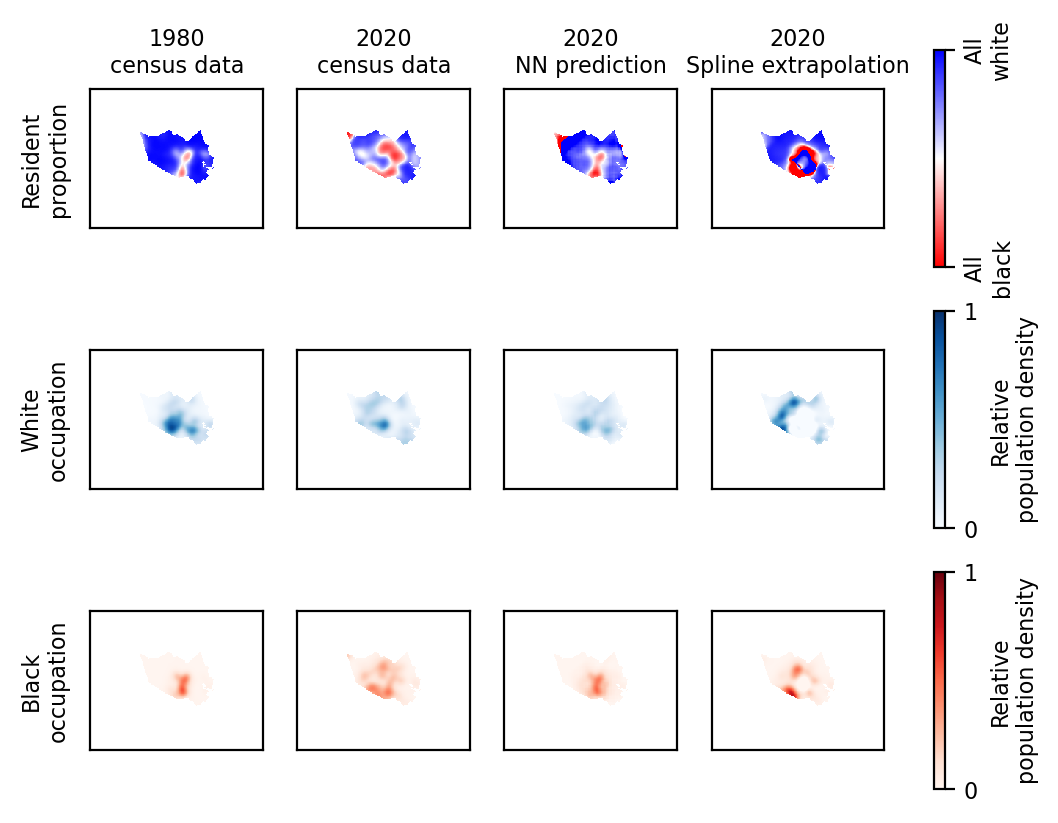

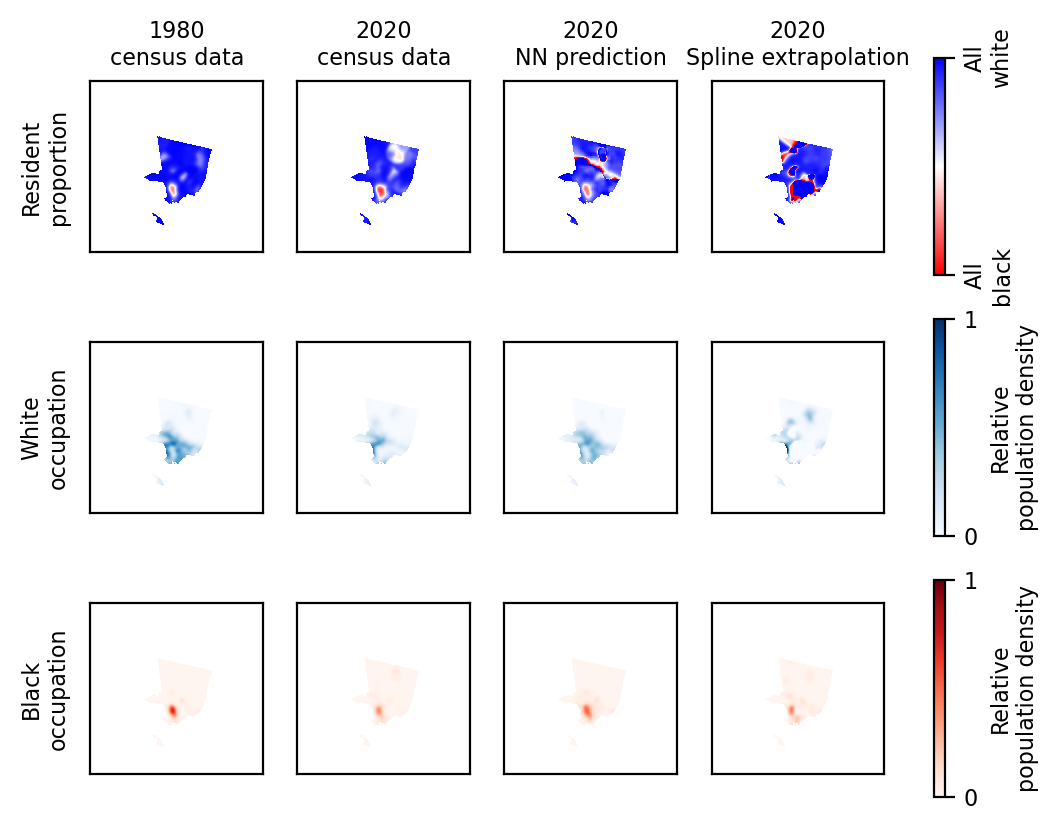

In [9]:
from train_census_nn import *
from pprint import pprint
import json

from postprocessing import make_predictions_plot


sub_df = df[(df.objective == 'Relative density') & (df.sigma == 4)].reset_index(drop=True)
model = os.path.basename(sub_df.loc[sub_df.rel_val_err.argmin(), 'path'])

with open(f'models/vary_sigma/{model}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Deal with rearranged paths
if model in os.listdir('models/vary_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/vary_sigma/')
elif model in os.listdir('models/fixed_sigma'):
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/fixed_sigma/')

model = get_model(config['model'])
model.to(device)
model.eval();

error = 0.

error += make_predictions_plot(model, 'Georgia_Fulton', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Illinois_Cook', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'Texas_Harris', config['dataset']['kwargs']);
error += make_predictions_plot(model, 'California_Los Angeles', config['dataset']['kwargs']);

print(f'Total error: {error:.5g}')

## Additional error calculation on models (including relative error)

In [16]:
import glob
import os
import yaml
import pandas as pd

from train_census_nn import get_model
from postprocessing import get_val_errors

def overwrite_val_error(path):
    """ For legacy models that computed val loss instead of val_err
    """
    with open(f'{path}/config.yaml', 'r') as f:
        config = yaml.safe_load(f)

    info = torch.load(f'{path}/model_weight.ckpt', map_location='cpu')
    if 'val_err' in info and 'rel_val_err' in info:
        print(f'Already have val_err in {path}')
        return

    # Fix rearranged paths
    config['model']['weights'] = config['model']['weights'].replace('models/', 'models/vary_sigma/')

    model = get_model(config['model'])
    model.to(device)
    model.eval();

    ret = get_val_errors(model, config['dataset']['val_counties'], config['dataset']['kwargs'])
    val_err = ret['val_err']
    rel_val_err = ret['rel_val_err']
    print(f'Found val err of {val_err:.5g} and relative err of {rel_val_err:.5g}', flush=True)
    info['val_err'] = val_err
    info['rel_val_err'] = rel_val_err
    torch.save(info, f'{path}/model_weight.ckpt')

    return val_err


# Recompute validation errors and get relative errors
for path in glob.glob('models/vary_sigma/*'):
    if not os.path.isdir(path): continue
    overwrite_val_error(path)

INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137618_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0072


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0072038 and relative err of 0.57658


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137618_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00579


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0057882 and relative err of 0.64469


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137633_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00791


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0079137 and relative err of 0.81745


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00943


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0094263 and relative err of 0.70306


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137618_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00788


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0078779 and relative err of 0.72204


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_2/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00586


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.005859 and relative err of 0.5558


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137633_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00439


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.0043909 and relative err of 0.49663


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0101


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010132 and relative err of 0.6398


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137633_1/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.00795


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.007954 and relative err of 0.57641


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137618_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0128


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.012786 and relative err of 0.73454


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137625_3/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0047


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.004704 and relative err of 0.54566


INFO:train_census_nn:Building a CensusForecasting
INFO:train_census_nn:Loading model weights from models/vary_sigma/4137633_0/model_weight.ckpt
INFO:train_census_nn:Model reached error=0.0109


Computing validation errors over ['Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris', 'California_Los Angeles']
Found val err of 0.010909 and relative err of 0.65662
